In [2]:
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from torchvision.models.segmentation.deeplabv3 import DeepLabHead
import torch.nn as nn
import torch.optim as optim
from scipy.ndimage import distance_transform_edt, gaussian_filter
import bz2
import pickle
import os
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error, confusion_matrix
import random
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import models_utils as mu
from sklearn.model_selection import train_test_split
import cv2
import time
from livelossplot import PlotLosses
import torchvision.transforms.functional as TF

Loading in the data 

In [3]:
df = pd.read_csv('final_dataset_filtered.csv') 

In [4]:
df.head()

img_path         xmin  \
0    Carlos Vera Guevara RGB_3_0_8305_4000_12305.png  3332.557861   
1    Carlos Vera Guevara RGB_3_0_8305_4000_12305.png  3162.579834   
2    Carlos Vera Guevara RGB_3_0_8305_4000_12305.png  2893.605713   
3    Carlos Vera Guevara RGB_3_0_8305_4000_12305.png  2595.111084   
4  Carlos Vera Guevara RGB_10_7600_7600_11600_116...   249.691879   

          ymin         xmax         ymax     score                 img_name  \
0    19.092411  3661.390137   364.616425  0.531211  Carlos Vera Guevara RGB   
1  2148.233398  3431.632324  2379.467041  0.511510  Carlos Vera Guevara RGB   
2   244.011108  3095.620605   451.257812  0.251310  Carlos Vera Guevara RGB   
3  1703.712402  2765.227295  1865.253418  0.217742  Carlos Vera Guevara RGB   
4   123.626862   439.557648   302.768402  0.282849  Carlos Vera Guevara RGB   

   tile_index  tile_xmin  tile_ymin  ...                     site  \
0           3          0       8305  ...  Carlos Vera Guevara RGB   
1           3          0       8305  ...  Carlos Vera Guevara RGB   
2           3          0       8305  ...  Carlos Vera Guevara RGB   
3           3          0       8305  ...  Carlos Vera Guevara RGB   
4          10       7600       7600  ...  Carlos Vera Guevara RGB   

           X_g          Y_g  updated diameter   group  updated height  \
0  5298.555843  7709.844671         10.281385  banana             0.0   
1  5315.345160  8606.745732         13.528139  banana             0.0   
2  5228.142461  7935.770200         12.732366  banana             0.0   
3  4434.058601  8354.081799          9.867583  banana             0.0   
4  8257.952942  7554.538338         17.825312  banana             0.0   

         AGB    carbon   id  unique_id  
0   4.293300  1.674387   30          1  
1   7.702971  3.004159  112          2  
2   6.769828  2.640233  179          3  
3   3.933601  1.534104   93          4  
4  13.862143  5.406236  162          5  

[5 rows x 44 columns]

In [5]:
df.shape

(2602, 44)

## Background Details for Class Weighting 

In [6]:
df['name'].value_counts()

name
Musacea               1471
Guaba                  523
Cacao                  233
Mango                   83
Otra variedad           80
Variedad bifurcada      71
Roble                   25
Melina                  16
Fernan Sanchez          16
Pachaco                 13
Guanabana               12
Caoba                   11
Guayacan                 8
Laurel                   6
Guachapeli               6
Achotillo                5
Sapote                   5
Yafruit                  5
Cedro                    4
Teca                     4
Naranja                  2
Fruta de Pan             1
Mandarina                1
MaraÃ±on                 1
Name: count, dtype: int64

In [7]:
#combining everything under 80 to 'other'
df['name'] = df['name'].apply(lambda x: x if x in ['Musacea','Guaba','Cacao','Mango'] else 'Otra variedad')

In [8]:
df['name'].value_counts()

name
Musacea          1471
Guaba             523
Otra variedad     292
Cacao             233
Mango              83
Name: count, dtype: int64

## Visualizing a Generated Distance Map

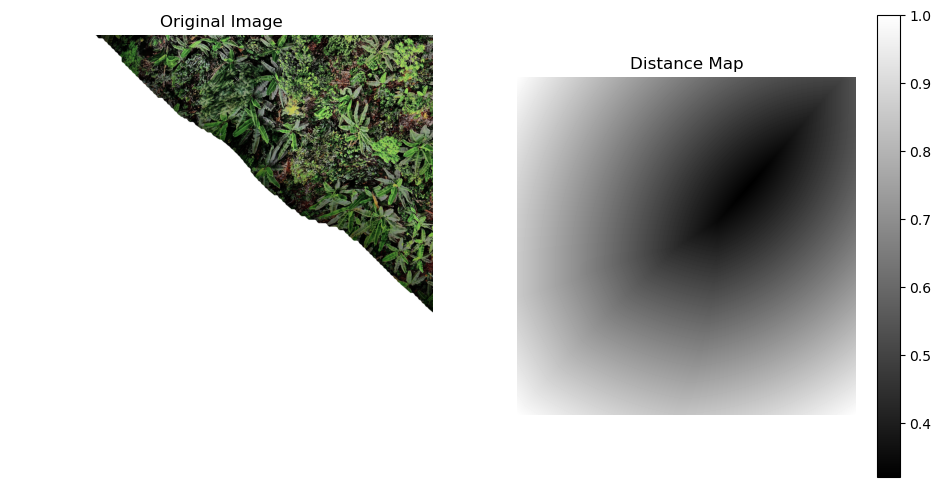

In [9]:
distance_map_dir = 'data/precomputed_distance_maps'
image_dir = 'data/tiles/processed'
img_path = 'Nestor Macias RGB_3_0_9024_4000_13024.png'  
mu.visualize_distance_map(distance_map_dir, img_path, image_dir)

## Loading and Visualizing Data

### Custom Transfomer

In [10]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.Lambda(lambda img: mu.random_rotation(img)),  # Ensure mu.random_rotation operates on tensors
])

I will also need a separate transformer for the test data because I don't want to augment it with flips and rotations

In [11]:
test_transform = transforms.Compose([
    transforms.ToTensor()
])

### Splitting and Loading the Data

In [12]:
#smaller dataset for testing
df_small = df.sample(100, random_state=42)

My current data is in the form where each row coordinates to a specific tree, but there are multiple trees within a tile. I want to split my data so all the trees in a given tile are together, so it will require some custom splitting. 

In [15]:
tiles = df_small['img_path'].unique()
np.random.seed(42)
np.random.shuffle(tiles)

# Calculate split indices
train_end = int(0.7 * len(tiles))
val_end = int(0.87 * len(tiles))

# Split the tiles
train_tiles = tiles[:train_end]
val_tiles = tiles[train_end:val_end]
test_tiles = tiles[val_end:]

In [16]:
train_df = df[df['img_path'].isin(train_tiles)]
val_df = df[df['img_path'].isin(val_tiles)]
test_df = df[df['img_path'].isin(test_tiles)]

print(f'Training set size: {len(train_df)}')
print(f'Validation set size: {len(val_df)}')
print(f'Testing set size: {len(test_df)}')

Training set size: 1315
Validation set size: 266
Testing set size: 272


In [17]:
root_dir = 'data/tiles/processed'

In [14]:
train_dataset = mu.TreeCrownDataset(dataframe=train_df, root_dir=root_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=0)

val_dataset = mu.TreeCrownDataset(dataframe=val_df, root_dir=root_dir, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=True, num_workers=0)

test_dataset = mu.TestDataset(dataframe=test_df, root_dir=root_dir, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=True, num_workers=0)

## Testing Data Loaded Correctly 

measuring how long it takes to load a training batch

In [15]:
start_time = time.time()

data_iter = iter(train_loader)
images, species, distance, ID = next(data_iter)

end_time = time.time()
print(f"Time to process one batch: {end_time - start_time} seconds")

BBox: (479, 3094, 626, 3245), Species Label: 5, ID Label: 1958
BBox: (3380, 2588, 3607, 2822), Species Label: 1, ID Label: 174
Time to process one batch: 4.017811059951782 seconds


And a testing batch

In [16]:
start_time = time.time()

data_iter = iter(test_loader)
images, species, distance, ID = next(data_iter)

end_time = time.time()
print(f"Time to process one batch: {end_time - start_time} seconds")

BBox: (393, 3206, 587, 3408), Species Label: 5, ID Label: 1619
BBox: (3213, 2849, 3439, 3073), Species Label: 1, ID Label: 171
Time to process one batch: 2.4800000190734863 seconds


Good, this makes sense the test batch is faster because you don't have to deal with cropping. 

In [17]:
from matplotlib.colors import ListedColormap, BoundaryNorm
species_values = [0.0, 1, 2, 3, 4, 5]
species_colors = ['purple', 'red', 'blue', 'green', 'yellow', 'orange']
species_names = ["Background", "Musacea", "Guaba", "Cacao", "Mango", "Otra Variedad"]
cmap = ListedColormap(species_colors)
norm = BoundaryNorm(species_values + [species_values[-1] + 0.001], cmap.N)

In [18]:
def show_images_with_legend(images, nrow=2, ncol=4, title=None, cmap=None, norm=None, legend_patches=None):
    fig, axes = plt.subplots(nrow, ncol, figsize=(12, 12))
    if title:
        fig.suptitle(title, fontsize=16)
        
    for i, img in enumerate(images):
        if i >= nrow * ncol:
            break
        ax = axes[i // ncol, i % ncol]
        
        # Convert img to numpy array if it's a tensor
        if isinstance(img, torch.Tensor):
            img = img.numpy()
        
        # Remove any singleton dimensions and handle batch dimension
        img = np.squeeze(img)
        
        # If img still has 3 dimensions and first dimension is batch size, select the first in the batch
        if img.ndim == 3 and img.shape[0] > 1:
            img = img[0]
        
        unique, counts = np.unique(img, return_counts=True)
        print(f"Image {i} unique values and counts: {dict(zip(unique, counts))}")
        
        # Ensure img has 2 dimensions for cmap and norm
        ax.imshow(img, cmap=cmap, norm=norm)
        ax.axis('off')

    # Add the legend to the figure outside the subplots
    if legend_patches:
        fig.legend(handles=legend_patches, loc='upper right', fontsize='small')
        
    plt.tight_layout()
    plt.show()

### Making sure there are distinct classes

In [19]:
train_class_distribution = mu.analyze_class_distribution(test_loader)
print(train_class_distribution)

BBox: (3425, 4, 3743, 139), Species Label: 2, ID Label: 1553
BBox: (2635, 2782, 2909, 3037), Species Label: 1, ID Label: 1271
BBox: (393, 3206, 587, 3408), Species Label: 5, ID Label: 1619
BBox: (2769, 2293, 3099, 2622), Species Label: 1, ID Label: 1390
BBox: (2357, 1738, 2575, 1961), Species Label: 1, ID Label: 1209
BBox: (1184, 3082, 1487, 3389), Species Label: 1, ID Label: 1456
BBox: (307, 3640, 585, 3964), Species Label: 2, ID Label: 2056
BBox: (224, 2766, 466, 3021), Species Label: 1, ID Label: 1300
BBox: (215, 1064, 527, 1383), Species Label: 1, ID Label: 508
BBox: (3832, 1741, 4000, 1963), Species Label: 1, ID Label: 176
BBox: (0, 3014, 134, 3295), Species Label: 1, ID Label: 1174
BBox: (0, 3, 248, 264), Species Label: 2, ID Label: 2165
BBox: (2567, 3618, 2795, 3888), Species Label: 1, ID Label: 765
BBox: (3213, 2849, 3439, 3073), Species Label: 1, ID Label: 171
BBox: (287, 1308, 659, 1684), Species Label: 1, ID Label: 655
{0: 238954763, 1: 808319, 2: 197730, 5: 39188}


### Training: visualizing one tree for confirmation of proper tree and distance maps

In [20]:
from matplotlib.patches import Patch
data_iter = iter(train_loader)
images, species_maps, dist_maps, ID_maps = next(data_iter)

BBox: (2302, 3556, 2460, 3702), Species Label: 5, ID Label: 1806
BBox: (33, 675, 331, 981), Species Label: 1, ID Label: 835


In [21]:
images.size(), species_maps.size(), dist_maps.size(), ID_maps.size()

(torch.Size([2, 8, 3, 224, 224]),
 torch.Size([2, 8, 224, 224]),
 torch.Size([2, 8, 224, 224]),
 torch.Size([2, 8, 224, 224]))

In [22]:
images_reshaped = images.view(-1, images.size(2), images.size(3), images.size(4))
species_maps_reshaped = species_maps.view(-1, species_maps.size(2), species_maps.size(3))
dist_maps_reshaped = dist_maps.view(-1, dist_maps.size(2), dist_maps.size(3))

In [23]:
images_reshaped.size(), species_maps_reshaped.size(), dist_maps_reshaped.size(), ID_maps.size()

(torch.Size([16, 3, 224, 224]),
 torch.Size([16, 224, 224]),
 torch.Size([16, 224, 224]),
 torch.Size([2, 8, 224, 224]))

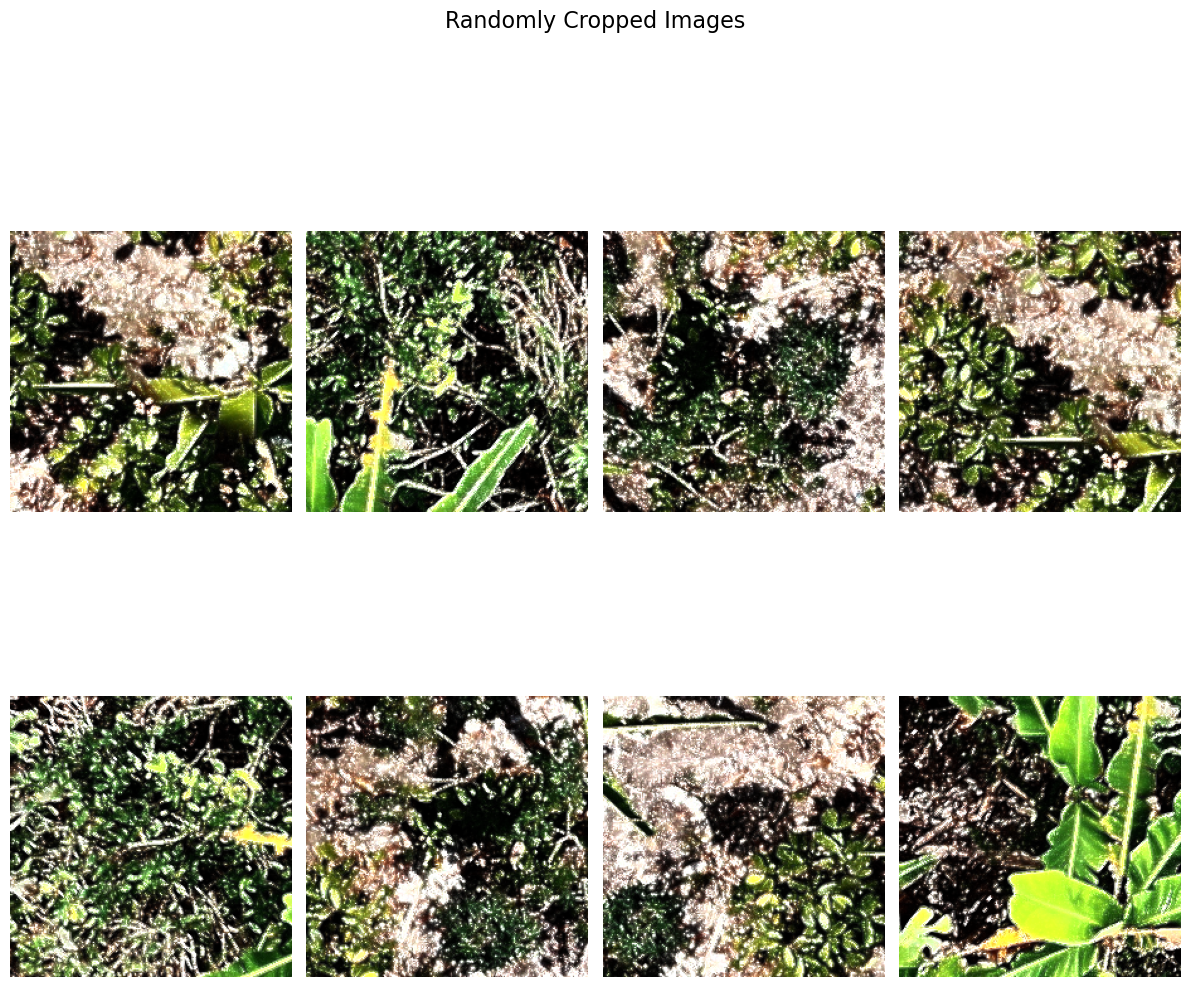

Image 0 unique values and counts: {0: 44190, 5: 5986}
Image 1 unique values and counts: {0: 15680, 1: 34496}
Image 2 unique values and counts: {0: 41734, 5: 8442}
Image 3 unique values and counts: {0: 35138, 5: 15038}
Image 4 unique values and counts: {0: 5376, 1: 44800}
Image 5 unique values and counts: {0: 39567, 5: 10609}
Image 6 unique values and counts: {0: 31300, 5: 18876}
Image 7 unique values and counts: {0: 33600, 1: 16576}


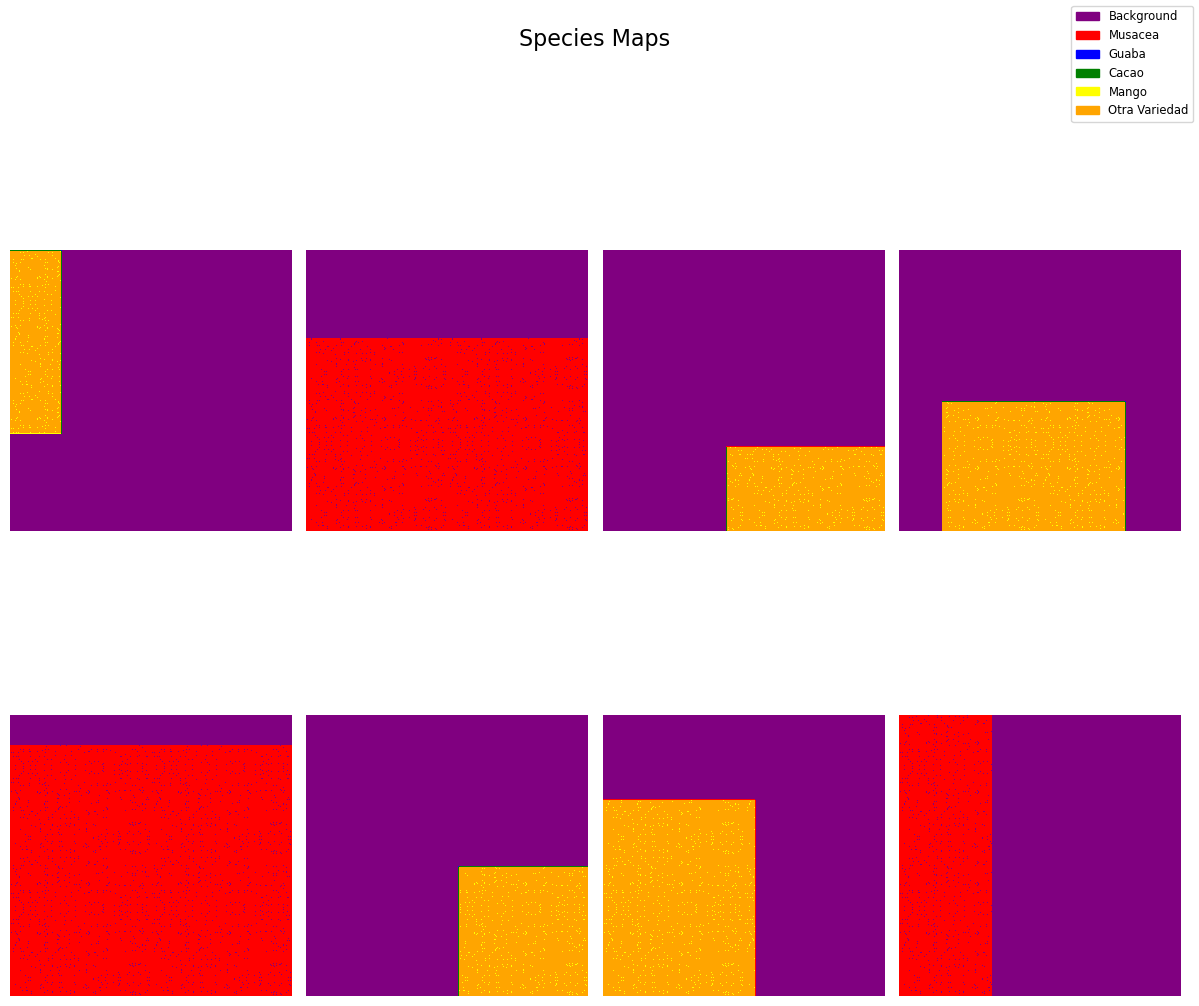

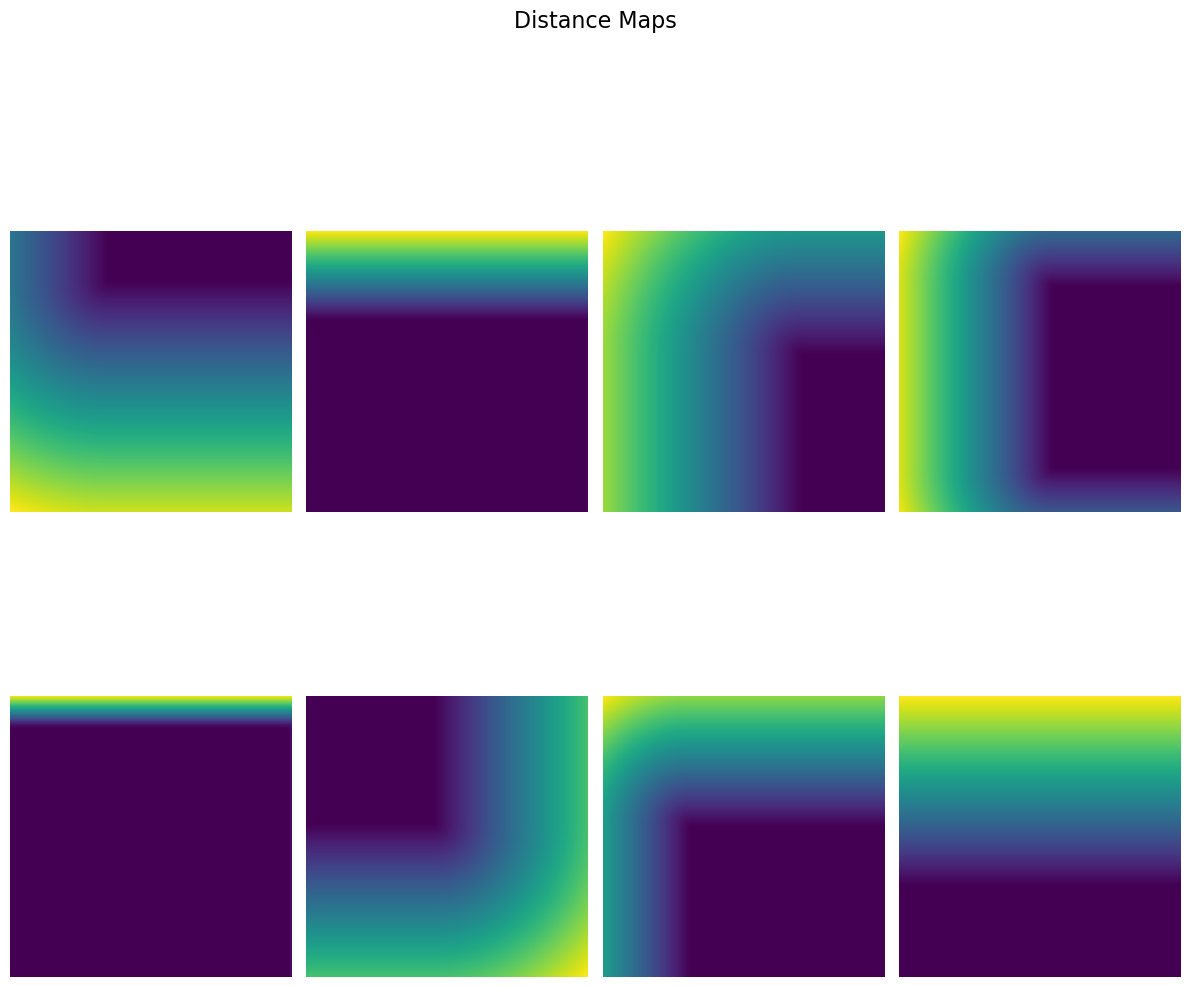

In [24]:

# Select 8 random images from the batch
num_images_to_show = 8
indices = random.sample(range(images_reshaped.size(0)), num_images_to_show)

selected_images = [images_reshaped[i] for i in indices]
selected_species = [species_maps_reshaped[i] for i in indices]
selected_distance = [dist_maps_reshaped[i] for i in indices]

legend_patches = [Patch(color=species_colors[i], label=species_names[i]) for i in range(len(species_values))]

# Show the images
mu.show_images(selected_images, nrow=2, ncol=4, title="Randomly Cropped Images")
show_images_with_legend(selected_species, nrow=2, ncol=4, title="Species Maps", cmap=cmap, norm=norm, legend_patches=legend_patches)
mu.show_images(selected_distance, nrow=2, ncol=4, title="Distance Maps")

### Testing: visualizing one tree for confirmation of proper tree and distance maps

In [25]:
data_iter = iter(test_loader)
images, species_maps, dist_maps, ID_maps = next(data_iter)

BBox: (3213, 2849, 3439, 3073), Species Label: 1, ID Label: 171
BBox: (3832, 1741, 4000, 1963), Species Label: 1, ID Label: 176


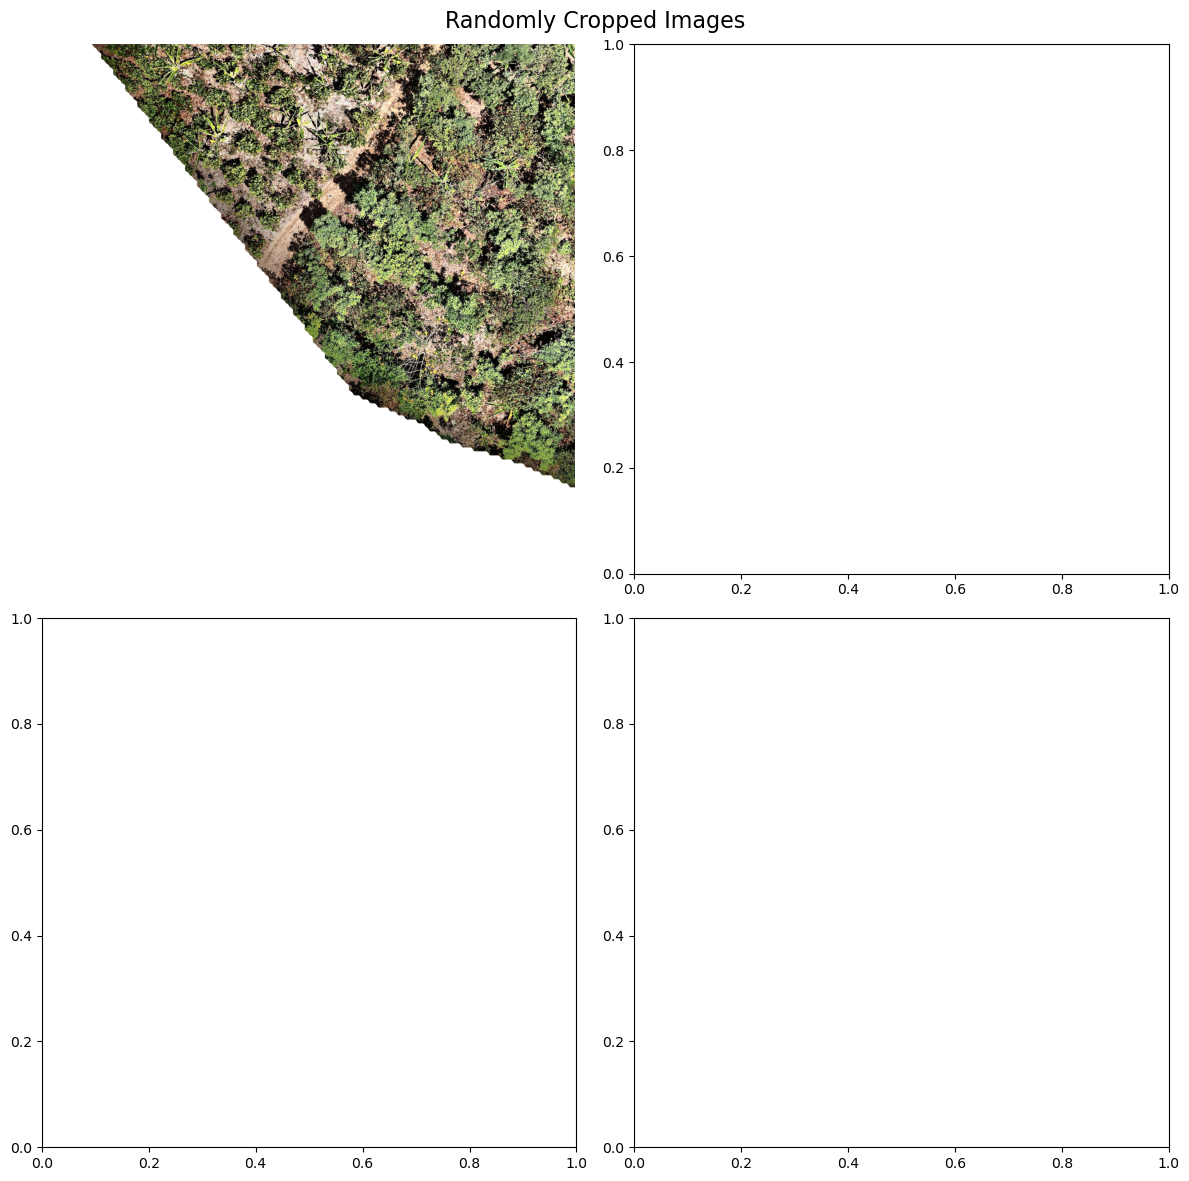

Image 0 unique values and counts: {0: 15949376, 1: 50624}


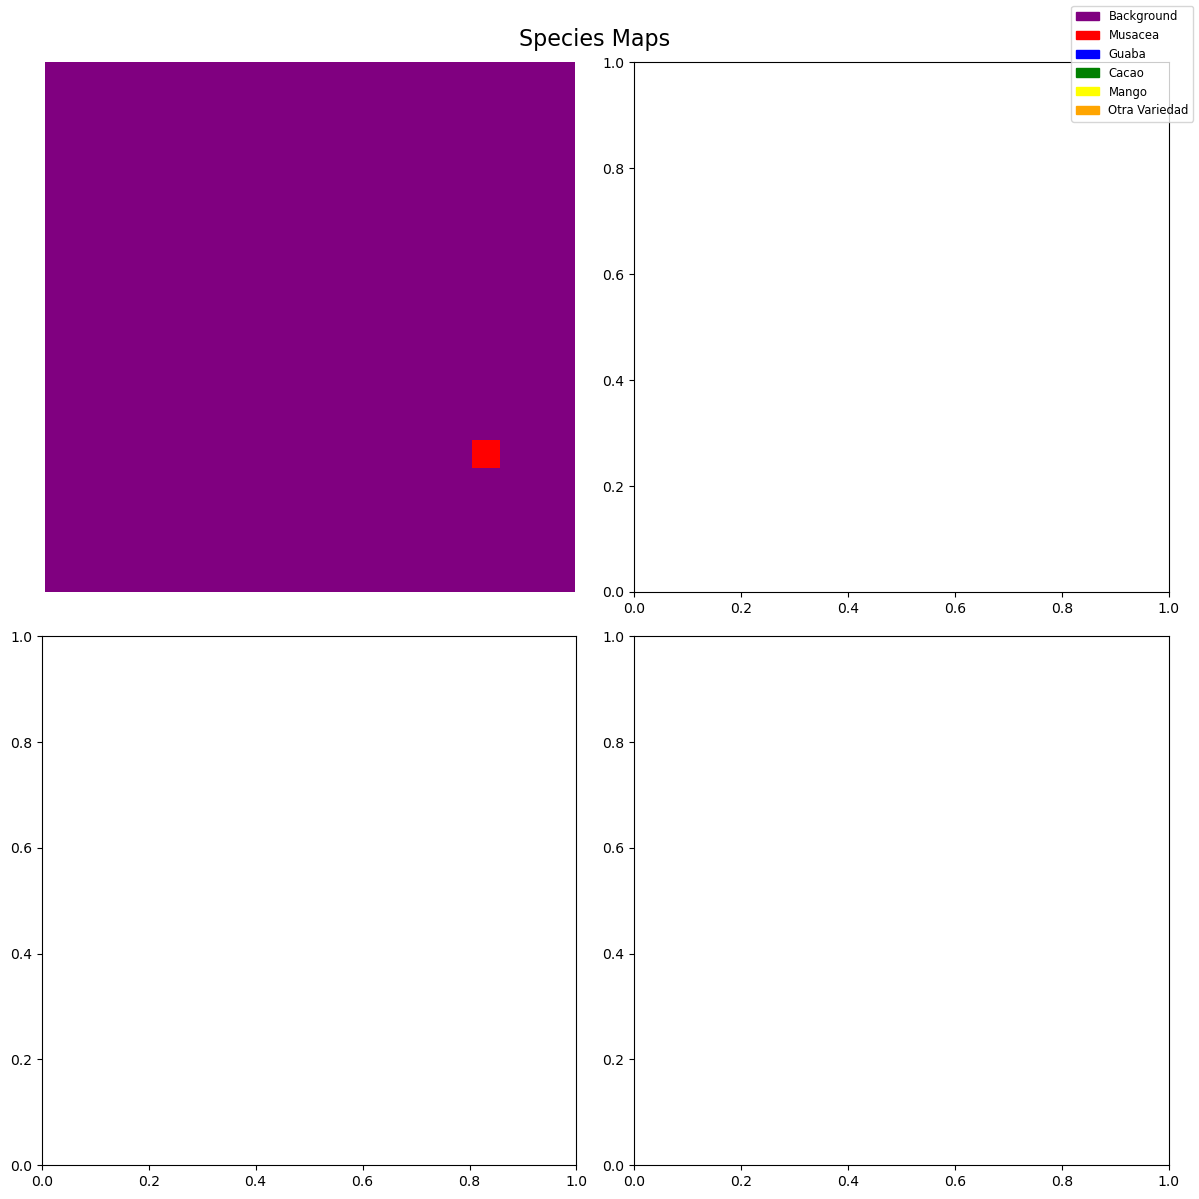

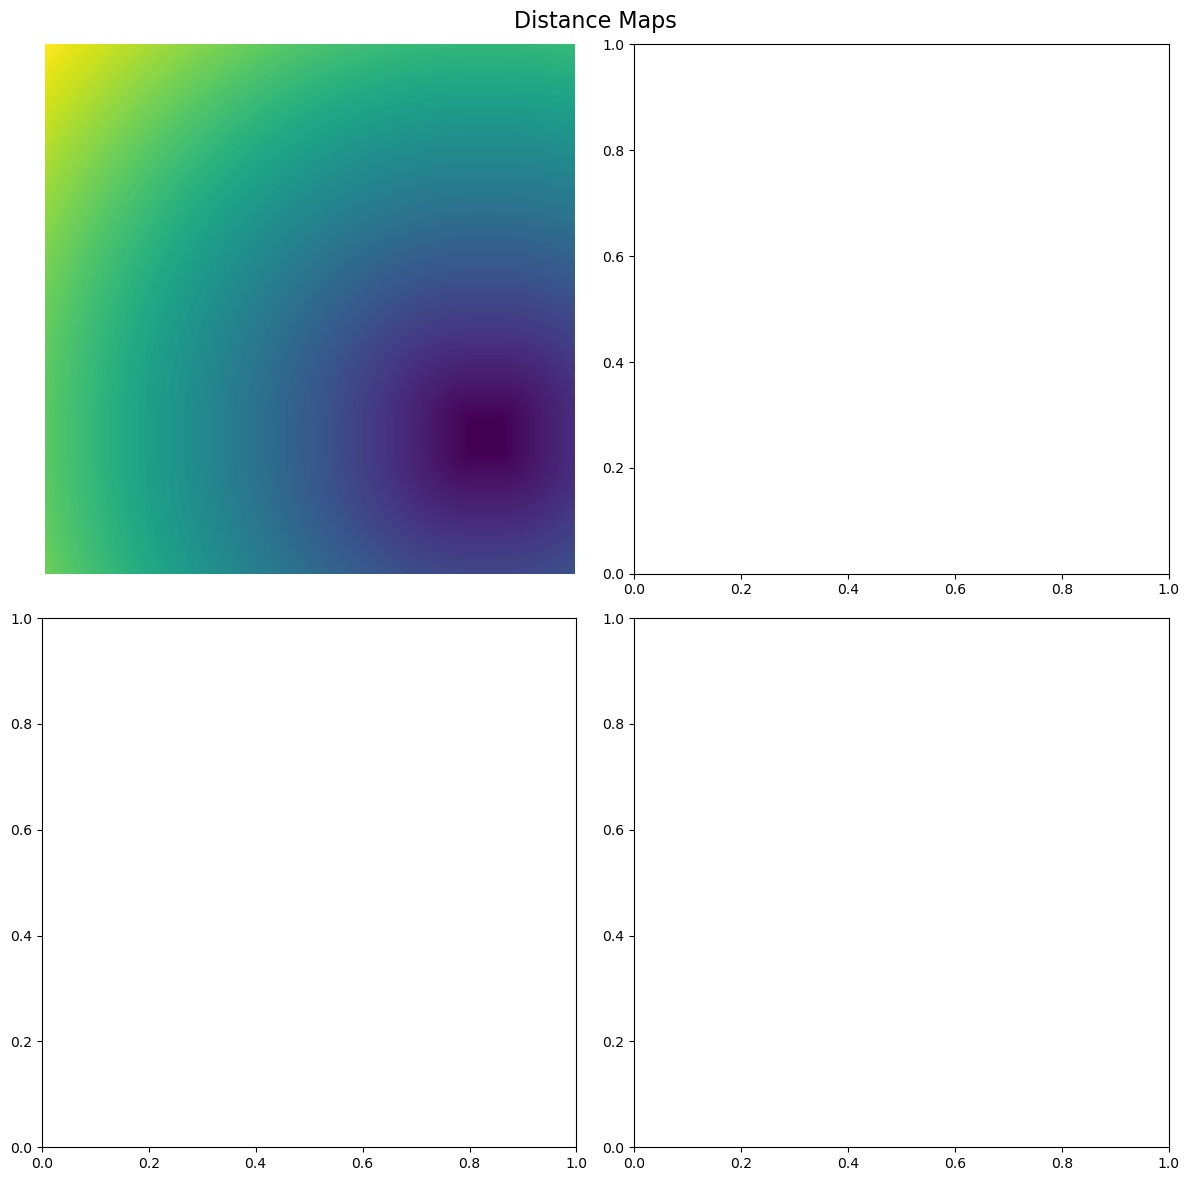

In [26]:
# Will look weird because I only have one image to show
num_images_to_show = 1
indices = random.sample(range(images.size(0)), num_images_to_show)

selected_images = [images[i] for i in indices]
selected_species = [species_maps[i] for i in indices]
selected_distance = [dist_maps[i] for i in indices]

legend_patches = [Patch(color=species_colors[i], label=species_names[i]) for i in range(len(species_values))]

# Show the images
mu.show_images(selected_images, nrow=2, ncol=2, title="Randomly Cropped Images")
show_images_with_legend(selected_species, nrow=2, ncol=2, title="Species Maps", cmap=cmap, norm=norm, legend_patches=legend_patches)
mu.show_images(selected_distance, nrow=2, ncol=2, title="Distance Maps")

______

# Running the Model

## Setting Device

In [27]:
device = mu.set_device("cuda")

No GPU available! Running on CPU


## Training the Model 

In [28]:
semantic_loss_fn = mu.PartiallyWeightedCategoricalFocalLoss(alpha=0.25).to(device)
distance_loss_fn = nn.MSELoss().to(device)
num_epochs = 2
model = mu.SEDDModel(num_classes=6).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

/opt/homebrew/Caskroom/miniconda/base/envs/IRP_2/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/IRP_2/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<Figure size 640x480 with 0 Axes>

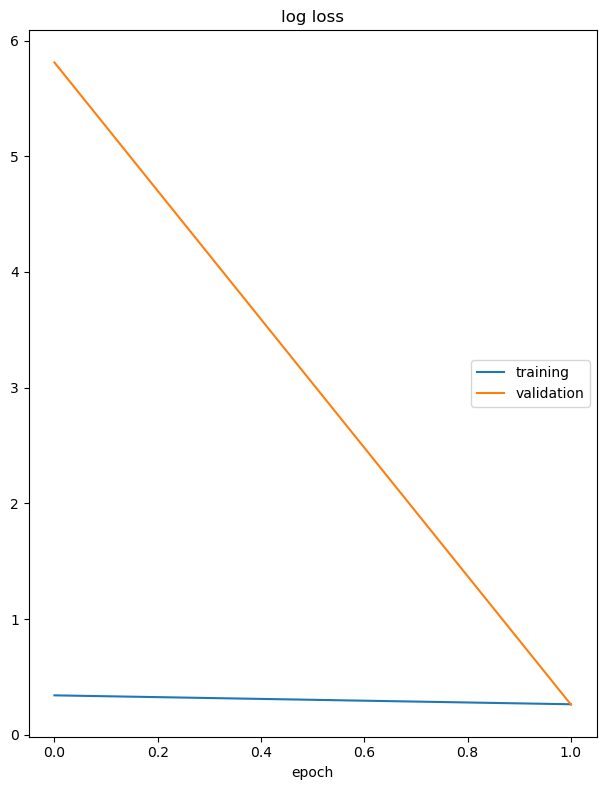

log loss
	training         	 (min:    0.264, max:    0.341, cur:    0.264)
	validation       	 (min:    0.261, max:    5.811, cur:    0.261)
Epoch [2/2], Train Loss: 0.2641, Validation Loss: 0.2611


<Figure size 640x480 with 0 Axes>

In [29]:
liveplot = PlotLosses()

start = time.time()

for epoch in range(num_epochs):
    logs = {}
    print(f'Epoch {epoch+1}/{num_epochs}')
    
    train_loss = mu.fit(model, train_loader, optimizer, semantic_loss_fn, distance_loss_fn, device)
    print(f'Fittting took {time.time()-start} seconds')
    val_loss = mu.validate(model, val_loader, semantic_loss_fn, distance_loss_fn, device)
    print(f'Validation took {time.time()-start} seconds')
    
    logs['log loss'] = train_loss
    logs['val_log loss'] = val_loss

    liveplot.update(logs)
    liveplot.draw()

    scheduler.step()

    # Save the plot to a file
    plt.savefig(f'live_plot_epoch_{epoch+1}.png')

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

# Save the model
torch.save(model.state_dict(), "SEDDModel_small.pth")

## Code to Evaluate

## Testing the in-notebook model

In [30]:
model_notebook = mu.SEDDModel(6)
model_notebook.load_state_dict(torch.load('SEDDModel_small.pth',map_location=torch.device('cpu')))

<All keys matched successfully>

In [31]:
model_notebook.eval()
model_notebook.to(device)

SEDDModel(
  (encoder): ResNet18Encoder(
    (resnet): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, 

## Sliding Window Evaluation

In [32]:
# Evaluate model using sliding window inference on full-size images
patch_size = (224, 224)  # Patch size
stride = (112, 112)  # 50% overlap

In [33]:
accuracy, precision, recall, f1, mse, species_maps, distance_maps = mu.evaluate_sliding_window(model_notebook, test_loader, patch_size, stride, device)

print(f'Test Accuracy: {accuracy:.4f}')
print(f'Test Precision: {precision:.4f}')
print(f'Test Recall: {recall:.4f}')
print(f'Test F1 Score: {f1:.4f}')
print(f'Test Distance Map MSE: {mse:.4f}')

BBox: (215, 1064, 527, 1383), Species Label: 1, ID Label: 508
BBox: (2357, 1738, 2575, 1961), Species Label: 1, ID Label: 1209
BBox: (2635, 2782, 2909, 3037), Species Label: 1, ID Label: 1271
BBox: (287, 1308, 659, 1684), Species Label: 1, ID Label: 655
BBox: (1184, 3082, 1487, 3389), Species Label: 1, ID Label: 1456
BBox: (3213, 2849, 3439, 3073), Species Label: 1, ID Label: 171
BBox: (393, 3206, 587, 3408), Species Label: 5, ID Label: 1619
BBox: (0, 3, 248, 264), Species Label: 2, ID Label: 2165
BBox: (307, 3640, 585, 3964), Species Label: 2, ID Label: 2056
BBox: (3832, 1741, 4000, 1963), Species Label: 1, ID Label: 176
BBox: (2769, 2293, 3099, 2622), Species Label: 1, ID Label: 1390
BBox: (224, 2766, 466, 3021), Species Label: 1, ID Label: 1300
BBox: (3425, 4, 3743, 139), Species Label: 2, ID Label: 1553
BBox: (2567, 3618, 2795, 3888), Species Label: 1, ID Label: 765


: 

In [44]:
def visualize_maps_with_colorbar(species_maps, distance_maps, num_images=5):
    for i in range(num_images):  # Show the first num_images for example
        plt.figure(figsize=(14, 6))
        
        plt.subplot(1, 2, 1)
        species_img = plt.imshow(species_maps[i][0], cmap='tab20')  # Assuming the first channel has the species map
        plt.title(f'Species Classification Map for image {i}')
        plt.colorbar(species_img, ax=plt.gca(), fraction=0.046, pad=0.04, label='Species Label')

        unique_values = np.unique(species_maps[i])
        print(f"Unique values in species map for image {i}: {unique_values}")
        
        plt.subplot(1, 2, 2)
        distance_img = plt.imshow(distance_maps[i][0], cmap='viridis')  # Assuming the first channel has the distance map
        plt.title(f'Distance Map for image {i}')
        plt.colorbar(distance_img, ax=plt.gca(), fraction=0.046, pad=0.04, label='Distance Value')
        
        plt.show()

Unique values in species map for image 0: [-24349496. -24337746. -24332670. ...  40473464.  40482140.  40501636.]


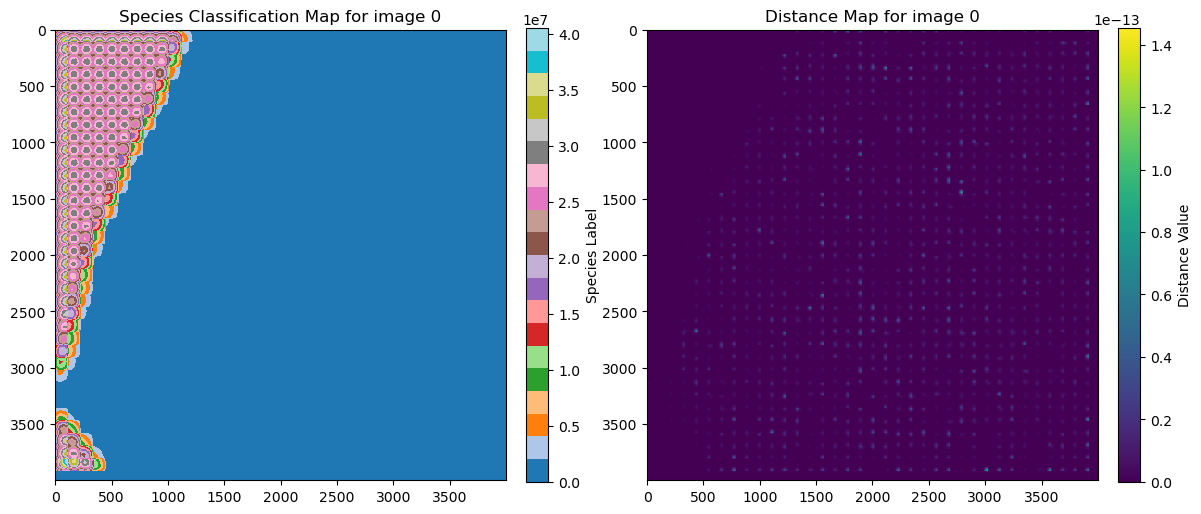

Unique values in species map for image 1: [-24349496. -24337746. -24332670. ...  40473464.  40482140.  40501636.]


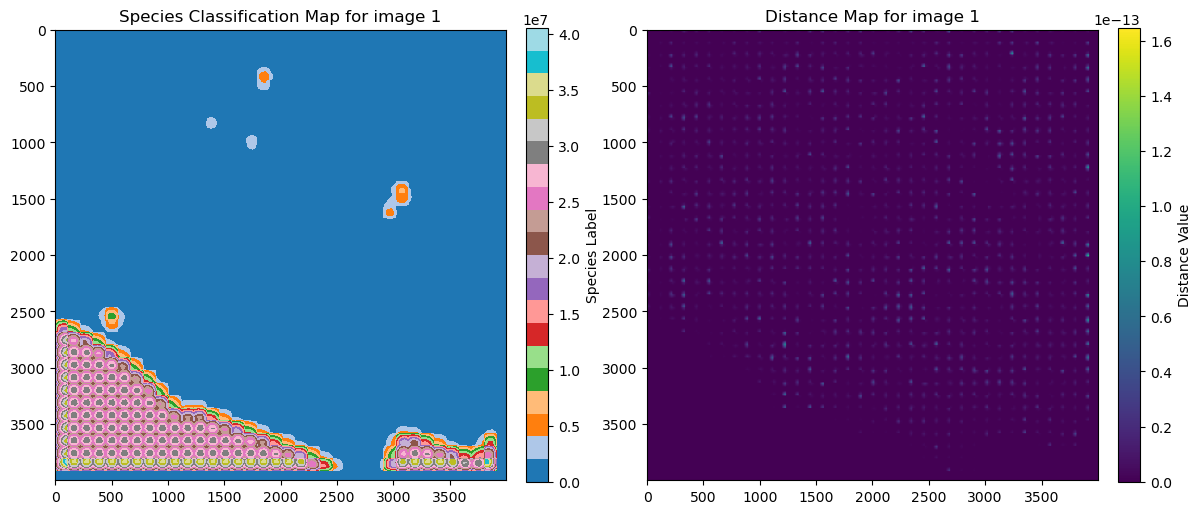

Unique values in species map for image 2: [-24363084. -24351332. -24349496. ...  40501636.  40504964.  40524452.]


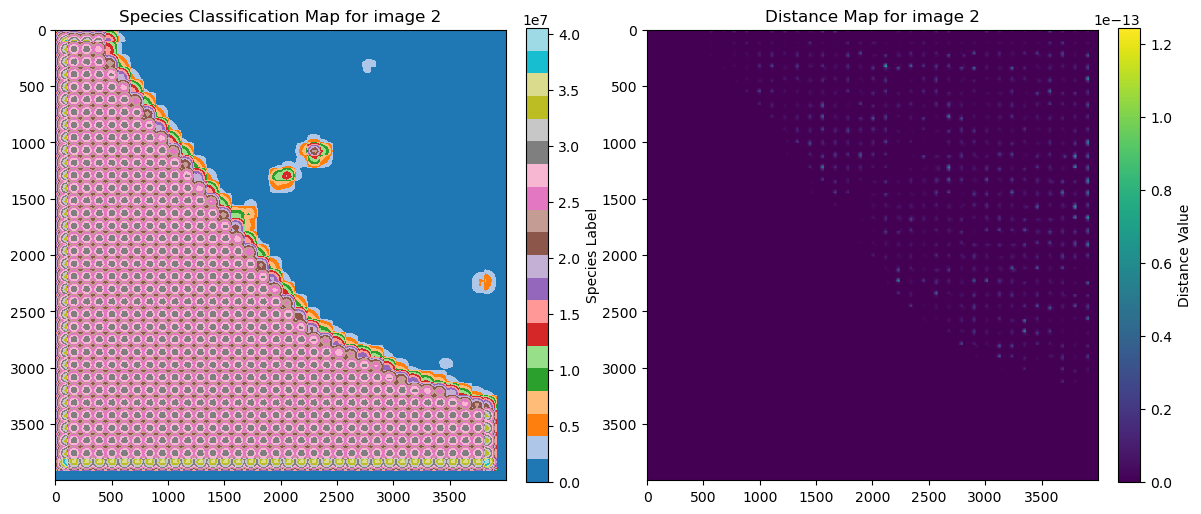

Unique values in species map for image 3: [-31472830. -31375914. -31355090. ...  52158376.  52192884.  52354340.]


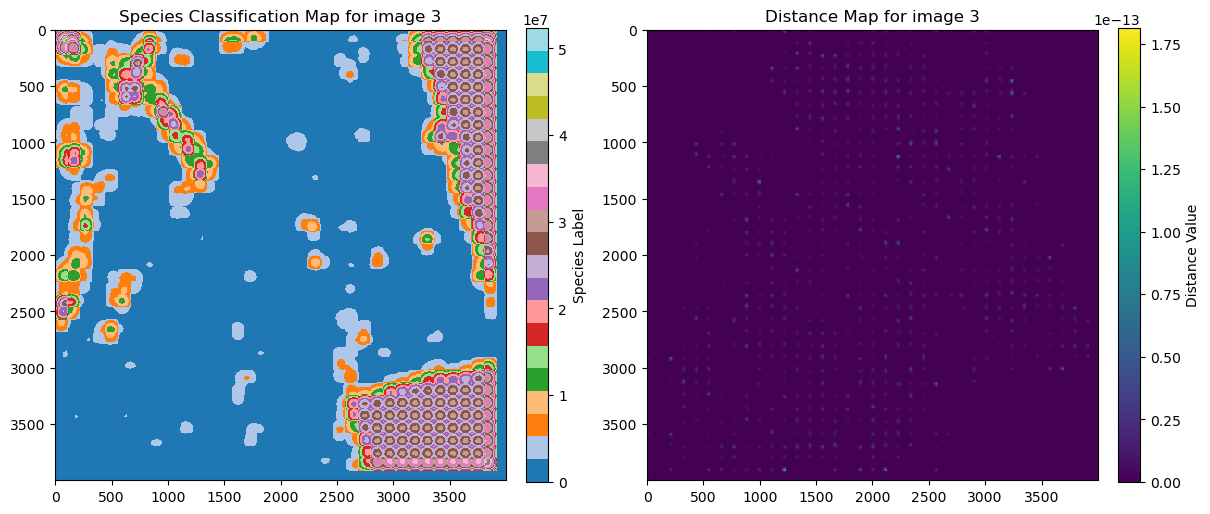

Unique values in species map for image 4: [-31472830. -31375914. -31355090. ...  52158376.  52192884.  52354340.]


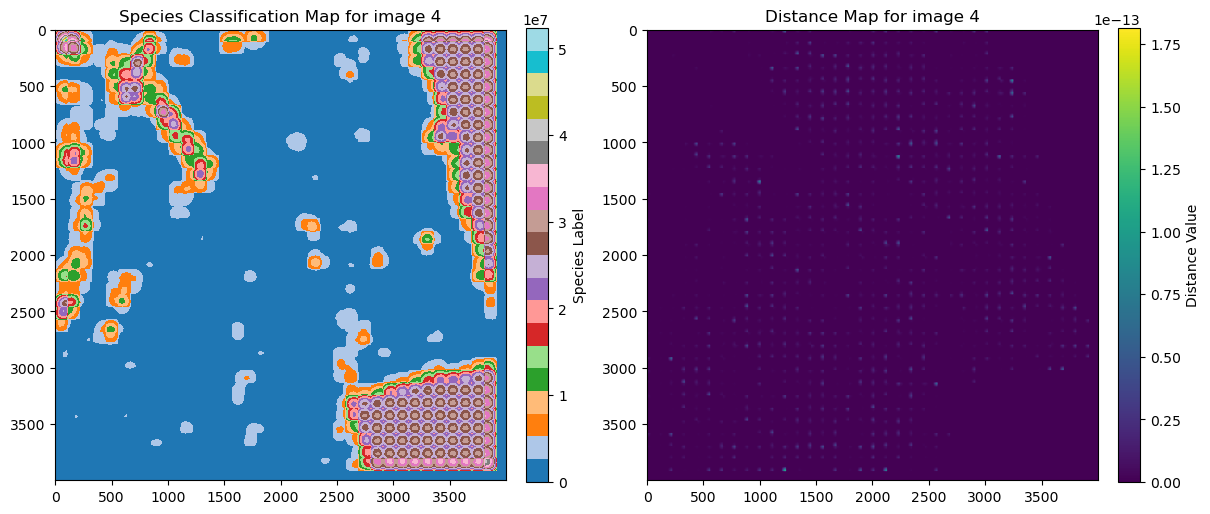

In [45]:
visualize_maps_with_colorbar(species_maps, distance_maps)